In [ ]:
# ! git clone https://github.com/akarshzingade/image-similarity-deep-ranking.git

Cloning into 'image-similarity-deep-ranking'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 76 (delta 6), reused 5 (delta 5), pack-reused 68
Unpacking objects: 100% (76/76), done.


In [3]:
%cd /content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking

/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking


In [ ]:
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 14.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [2]:
import tensorflow as tf
tf.__version__

import h5py
h5py.__version__

'3.1.0'

In [ ]:
! pip uninstall tensorflow

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [ ]:
! pip install tensorflow==1.15
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 16 kB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 63.3 MB/s 
     |████████████████████████████████| 503 kB 90.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9492bb74a011d56d67f16088f0f74c6aec593c9ae4658edd8a8b0e53d46539cd
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 14.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


#커널 다시 시작 후 여기서부터

In [ ]:
%cd /content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking

# sampler 파일 생성할때만 실행

In [ ]:
# !python tripletSampler.py --input_directory /content/drive/MyDrive/similar/class/ --output_directory tripletTxt/ --num_pos_images 4 --num_neg_images 6

Input Directory: /content/drive/MyDrive/similar/class/
Output Directory: tripletTxt/
Number of Positive image per Query image: 4
Number of Negative image per Query image: 6


In [ ]:
# coding: utf-8

from  __future__ import absolute_import
from __future__ import print_function
from ImageDataGeneratorCustom import ImageDataGeneratorCustom
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

def convnet_model_():
    vgg_model = VGG16(weights=None, include_top=False)
    x = vgg_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Lambda(lambda  x_: K.l2_normalize(x,axis=1))(x)
    convnet_model = Model(inputs=vgg_model.input, outputs=x)
    return convnet_model

def deep_rank_model():

    convnet_model = convnet_model_()
    first_input = Input(shape=(256,256,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(256,256,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: K.l2_normalize(x,axis=1))(emb)

    final_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    return final_model


deep_rank_model = deep_rank_model()

for layer in deep_rank_model.layers:
    print (layer.name, layer.output_shape)

model_path = "/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking/model_path/"

class DataGenerator(object):
    def __init__(self, params, target_size=(256, 256)):
        self.params = params
        self.target_size = target_size
        self.idg = ImageDataGeneratorCustom(**params)

    def get_train_generator(self, batch_size):
        return self.idg.flow_from_directory("/content/drive/MyDrive/similar/class/",
                                            batch_size=batch_size,
                                            target_size=self.target_size,shuffle=False,
                                            triplet_path  ='/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking/tripletTxt/triplets.txt'
                                           )

    def get_test_generator(self, batch_size):
        return self.idg.flow_from_directory("/content/drive/MyDrive/similar/class/",
                                            batch_size=batch_size,
                                            target_size=self.target_size, shuffle=False,
                                            triplet_path  ="/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking/tripletTxt/triplets.txt"                                        )



dg = DataGenerator({
    "rescale": 1. / 255,
    "horizontal_flip": True,
    "vertical_flip": True,
    "zoom_range": 0.2,
    "shear_range": 0.2,
    "rotation_range": 30,
"fill_mode": 'nearest' 
}, target_size=(256, 256))

batch_size = 16
batch_size *= 3
train_generator = dg.get_train_generator(batch_size)


_EPSILON = K.epsilon()
def _loss_tensor(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    loss =  tf.convert_to_tensor(0,dtype=tf.float32)
    g = tf.constant(1.0, shape=[1], dtype=tf.float32)
    for i in range(0,batch_size,3):
        try:
            q_embedding = y_pred[i+0]
            p_embedding =  y_pred[i+1]
            n_embedding = y_pred[i+2]
            D_q_p =  K.sqrt(K.sum((q_embedding - p_embedding)**2))
            D_q_n = K.sqrt(K.sum((q_embedding - n_embedding)**2))
            loss = (loss + g + D_q_p - D_q_n )            
        except:
            continue
    loss = loss/(batch_size/3)
    zero = tf.constant(0.0, shape=[1], dtype=tf.float32)
    return tf.maximum(loss,zero)

#deep_rank_model.load_weights('deepranking.h5')
deep_rank_model.compile(loss=_loss_tensor, optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True))


train_steps_per_epoch = int((15099)/batch_size)
train_epocs = 50
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose =1, patience = 10)
# mc = ModelCheckpoint(model_path+"best_model.h5", monitor = "val_loss",mode='min', save_best_only=True)
deep_rank_model.fit_generator(train_generator,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=train_epocs , callbacks = [early_stopping]
                       )

model_path2 = "/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking/model_path/deepranking_test_early.h5"
deep_rank_model.save_weights(model_path2)
#f = open('deepranking.json','w')
#f.write(deep_rank_model.to_json())
#f.close()


input_10 (None, None, None, 3)
block1_conv1 (None, None, None, 64)
block1_conv2 (None, None, None, 64)
block1_pool (None, None, None, 64)
block2_conv1 (None, None, None, 128)
block2_conv2 (None, None, None, 128)
block2_pool (None, None, None, 128)
block3_conv1 (None, None, None, 256)
block3_conv2 (None, None, None, 256)
block3_conv3 (None, None, None, 256)
block3_pool (None, None, None, 256)
block4_conv1 (None, None, None, 512)
block4_conv2 (None, None, None, 512)
block4_conv3 (None, None, None, 512)
block4_pool (None, None, None, 512)
block5_conv1 (None, None, None, 512)
block5_conv2 (None, None, None, 512)
block5_conv3 (None, None, None, 512)
block5_pool (None, None, None, 512)
input_11 (None, 256, 256, 3)
input_12 (None, 256, 256, 3)
global_average_pooling2d_4 (None, 512)
conv2d_7 (None, 16, 16, 96)
conv2d_8 (None, 8, 8, 96)
dense_10 (None, 4096)
max_pooling2d_7 (None, 4, 4, 96)
max_pooling2d_8 (None, 4, 4, 96)
dropout_7 (None, 4096)
flatten_7 (None, 1536)
flatten_8 (None, 1536)
den

/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


314/314 [==============================] - 477s 2s/step - loss: 0.9331
Epoch 3/50
314/314 [==============================] - 411s 1s/step - loss: 0.8125
Epoch 4/50
314/314 [==============================] - 461s 1s/step - loss: 0.8028
Epoch 5/50
314/314 [==============================] - 463s 1s/step - loss: 0.8253
Epoch 6/50
314/314 [==============================] - 457s 1s/step - loss: 0.9770
Epoch 7/50
314/314 [==============================] - 482s 2s/step - loss: 0.8846
Epoch 8/50
314/314 [==============================] - 563s 2s/step - loss: 0.6998
Epoch 9/50
314/314 [==============================] - 500s 2s/step - loss: 0.8381
Epoch 10/50
314/314 [==============================] - 426s 1s/step - loss: 1.0011
Epoch 11/50
314/314 [==============================] - 443s 1s/step - loss: 0.9566
Epoch 12/50
314/314 [==============================] - 462s 1s/step - loss: 0.9703
Epoch 13/50
314/314 [==============================] - 469s 1s/step - loss: 0.9559
Epoch 14/50
314/314 [==

In [ ]:
# !python deepranking_get_distance.py --model model_path/deepranking_test_early.h5 --image1 ../../similar/1188997_20211222_1_1_a1_1_2_13_3_196.jpg --image2 ../../similar/1179553_20211220_1_1_a2_1_2_13_3_176.jpg

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2022-09-11 10:36:03.261386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-11 10:36:03.282465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 10:36:03.283077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2022-09-11 10:36:03.283375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-11 10:36:03.284633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-11 10:36:03.2859

# 내사진과 비교할 사진 리스트 랜덤하게 리스트로 뽑아내기

In [5]:
import os,re
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]

path = "/content/drive/MyDrive/similar/class/"
classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
all_images = []

for class_ in classes:
    image_names = list_pictures(os.path.join(path,class_))
    for image_name in image_names:
        all_images.append(image_name)

In [6]:
import random
total= random.sample(all_images,10)

In [7]:
total # 비교할 사진 리스트 10개

['/content/drive/MyDrive/similar/class/class6/1213981_20211228_1_1_a1_1_2_13_3_476.jpg',
 '/content/drive/MyDrive/similar/class/class6/1042609_20211027_2_1_a6_3_2_12_3_112.jpg',
 '/content/drive/MyDrive/similar/class/class8/319933_20210916_6_1_a12_3_1_24_3_437.jpg',
 '/content/drive/MyDrive/similar/class/class8/286776_20210902_6_1_a12_3_1_24_1_389.jpg',
 '/content/drive/MyDrive/similar/class/class3/417441_20210928_2_2_b7_3_2_12_1_19.jpg',
 '/content/drive/MyDrive/similar/class/class3/1112769_20211202_5_2_b7_3_2_11_1_11.jpg',
 '/content/drive/MyDrive/similar/class/class6/604908_20211011_2_1_a6_3_2_12_2_137.jpg',
 '/content/drive/MyDrive/similar/class/class5/937605_20211106_2_2_b3_1_2_13_2_1832.jpg',
 '/content/drive/MyDrive/similar/class/class2/1086382_20211203_5_2_b6_3_2_13_3_66.jpg',
 '/content/drive/MyDrive/similar/class/class8/236541_20210820_6_1_a12_3_1_24_1_174.jpg']

# 유사도 거리 측정

In [9]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras import backend as K
import tensorflow as tf
import h5py

def convnet_model_():
    vgg_model = VGG16(weights=None, include_top=False)
    x = vgg_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Lambda(lambda  x_: K.l2_normalize(x,axis=1))(x)
    convnet_model = Model(inputs=vgg_model.input, outputs=x)
    return convnet_model

def deep_rank_model():
 
    convnet_model = convnet_model_()
    first_input = Input(shape=(256,256,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(256,256,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: K.l2_normalize(x,axis=1))(emb)

    final_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    return final_model


model1 = "/content/drive/MyDrive/deep-ranking/image-similarity-deep-ranking/model_path/deepranking_test_early.h5" 
# image1= "/content/drive/MyDrive/similar/1188997_20211222_1_1_a1_1_2_13_3_196.jpg" 
image1 = "/content/drive/MyDrive/similar/522721_20210813_5_2_b3_1_2_13_2_171.jpg"
# image1 = "/content/drive/MyDrive/similar/223913_20210818_6_1_a12_3_1_24_1_394.jpg"
# image2 ="/content/drive/MyDrive/similar/1179553_20211220_1_1_a2_1_2_13_3_176.jpg"

model = deep_rank_model()

# for layer in model.layers:
#     print (layer.name, layer.output_shape)

model.load_weights(model1)

image1 = load_img(image1)
image1 = img_to_array(image1).astype("float64")
image1 = transform.resize(image1, (256, 256))
image1 *= 1. / 255
image1 = np.expand_dims(image1, axis = 0)

embedding1 = model.predict([image1, image1, image1])[0]

distance_t,image_t = [], []
for image2 in total:
  image3 = load_img(image2)
  image3 = img_to_array(image3).astype("float64")
  image3 = transform.resize(image3, (256, 256))
  image3 *= 1. / 255
  image3 = np.expand_dims(image3, axis = 0)

  embedding2 = model.predict([image3,image3,image3])[0]

  distance = sum([(embedding1[idx] - embedding2[idx])**2 for idx in range(len(embedding1))])**(0.5)
  print (distance)
  # image2_sp = image2.split("/")
  # image_t.append(image2_sp[7])
  distance_t.append(distance)


TypeError: ignored

# 거리 dataframe으로 저장 및 거리순으로 정렬(오름차순)

In [ ]:
import pandas as pd
metadata = pd.DataFrame({"id":total, "distance": distance_t})

In [ ]:
metadata.sort_values("distance", inplace=True)
metadata.reset_index(drop=True)

,id,distance
0,/content/drive/MyDrive/similar/class/class5/52...,0.158383
1,/content/drive/MyDrive/similar/class/class6/12...,0.210177
2,/content/drive/MyDrive/similar/class/class5/52...,1.491900
3,/content/drive/MyDrive/similar/class/class2/91...,1.555023
4,/content/drive/MyDrive/similar/class/class4/98...,1.563833
5,/content/drive/MyDrive/similar/class/class3/11...,1.572692
6,/content/drive/MyDrive/similar/class/class6/60...,1.594521
7,/content/drive/MyDrive/similar/class/class4/94...,1.604456
8,/content/drive/MyDrive/similar/class/class6/60...,1.612055
9,/content/drive/MyDrive/similar/class/class1/41...,1.612144


# 유사한 이미지부터 출력

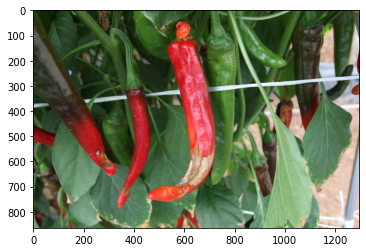

original```````````````


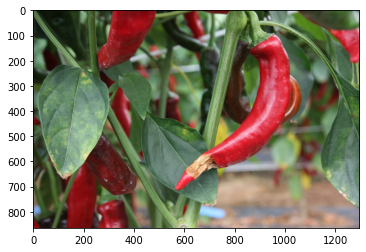

Image Category: /content/drive/MyDrive/similar/class/class5/527664_20210819_5_2_b3_1_2_13_2_260.jpg
Euclidean Distance: 0.15838327256825574


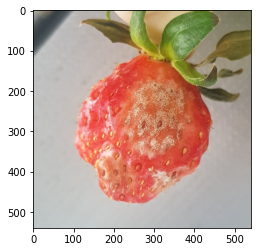

Image Category: /content/drive/MyDrive/similar/class/class6/1214105_20211228_1_1_a1_1_2_13_1_0.jpg
Euclidean Distance: 0.2101771074010494


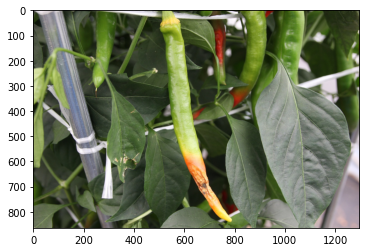

Image Category: /content/drive/MyDrive/similar/class/class5/524215_20210814_5_2_b3_1_2_13_2_237.jpg
Euclidean Distance: 1.491899944840652


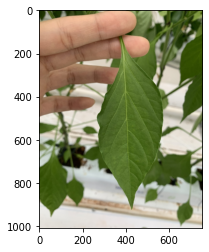

Image Category: /content/drive/MyDrive/similar/class/class2/918359_20211109_5_2_b6_3_2_13_1_80.jpg
Euclidean Distance: 1.5550227091839397


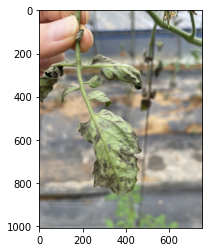

Image Category: /content/drive/MyDrive/similar/class/class4/985175_20211102_2_2_b8_3_2_11_3_546.jpg
Euclidean Distance: 1.5638328966780934


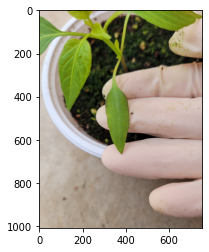

Image Category: /content/drive/MyDrive/similar/class/class3/1158645_20211209_5_2_b7_3_2_11_1_173.jpg
Euclidean Distance: 1.5726918415926505


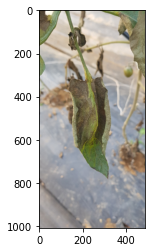

Image Category: /content/drive/MyDrive/similar/class/class6/607386_20211021_2_1_a6_3_2_12_2_241.jpg
Euclidean Distance: 1.594520853023518


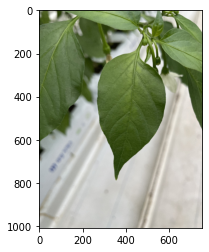

Image Category: /content/drive/MyDrive/similar/class/class4/945934_20211122_5_2_b8_3_2_13_1_257.jpg
Euclidean Distance: 1.604455716390452


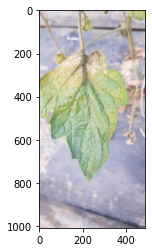

Image Category: /content/drive/MyDrive/similar/class/class6/605533_20211013_2_1_a6_3_2_12_2_158.jpg
Euclidean Distance: 1.6120554345198301


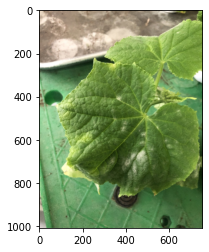

Image Category: /content/drive/MyDrive/similar/class/class1/415958_20211001_4_1_a4_3_2_11_1_107.jpg
Euclidean Distance: 1.6121442873362326


In [ ]:
import matplotlib.pyplot as plt
image1 = load_img("/content/drive/MyDrive/similar/522721_20210813_5_2_b3_1_2_13_2_171.jpg")
plt.imshow(image1)
plt.show()
print("original```````````````")

for i in range(len(total)):
  image = load_img('{}'.format(metadata['id'].values[i]))
  plt.imshow(image)
  plt.show()
  print('Image Category: {}'.format(metadata['id'].values[i]))
  print('Euclidean Distance: {}'.format(metadata['distance'].values[i]))